In [72]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per
import dataset_manipulations as dm

import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [84]:
import imp
imp.reload(per)
imp.reload(dm)

<module 'dataset_manipulations' from '../src/dataset_manipulations.py'>

In [20]:
# !curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvf cifar-10-python.tar.gz

(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


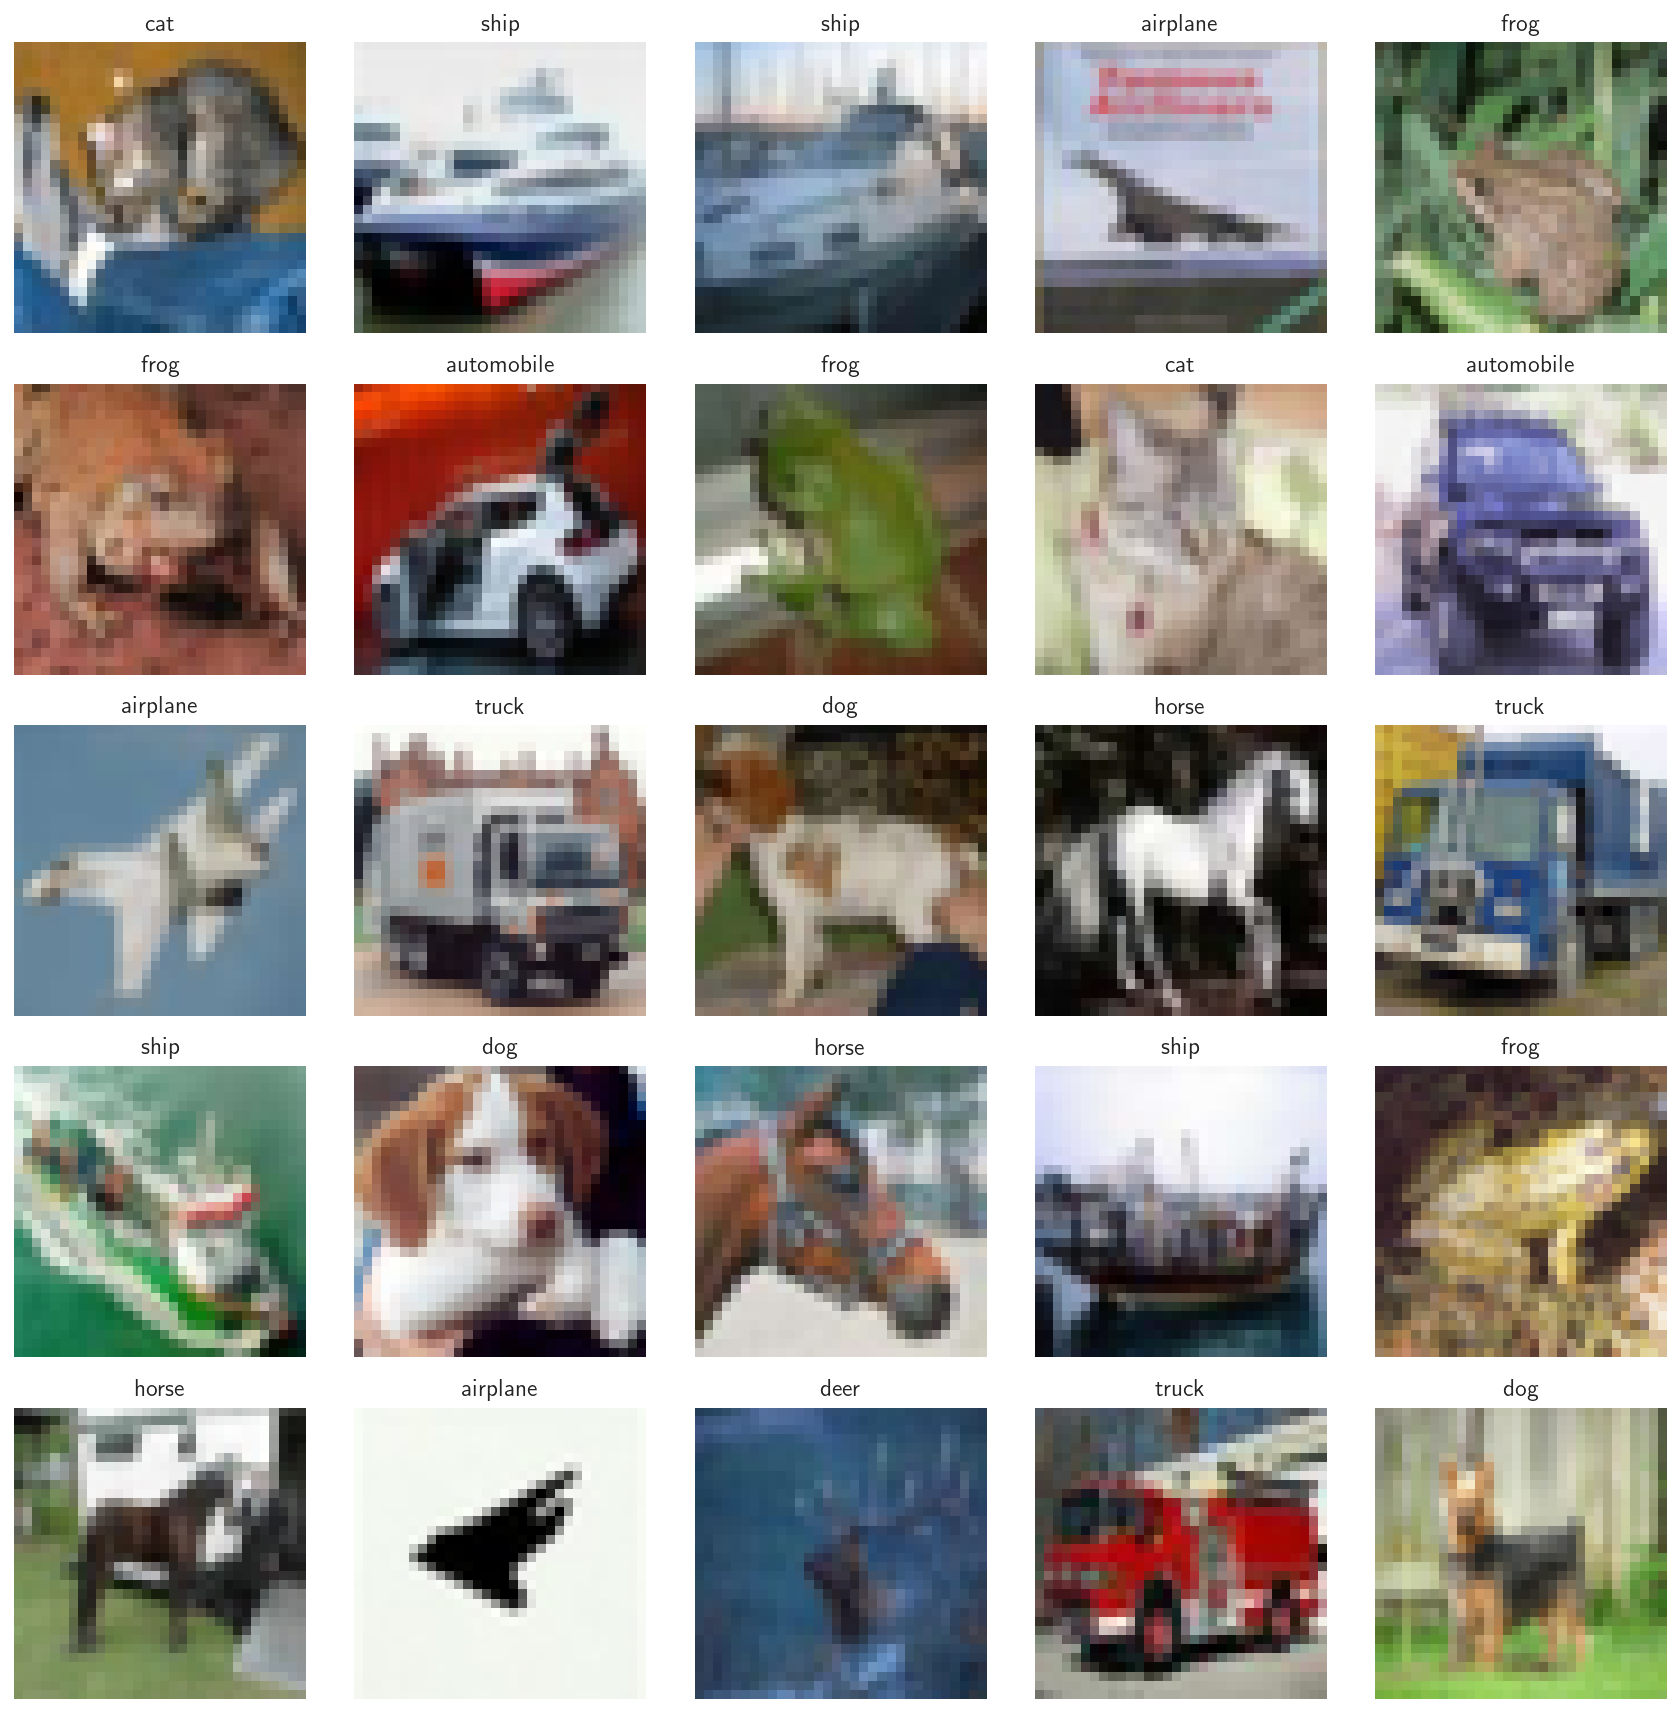

In [80]:
Xtrain, Ttrain = dm.load_cifar_10('./cifar-10-batches-py/data_batch_*')# load('data_batch_*')
Xtest, Ttest, = dm.load_cifar_10('./cifar-10-batches-py/test_batch') # load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']
classes = np.unique(Ttrain)
    
def imshow(Xset, Tset):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.moveaxis(Xset[i,...], 0, 2), interpolation='nearest')
        plt.axis('off')
        unicode = class_names[Tset[i][0]].decode('utf-8')
        plt.title(unicode) 

    plt.tight_layout()
    
imshow(Xtest, Ttest)

In [22]:
ex = Xtrain[np.random.randint(len(Xtrain))]

(-0.5, 31.5, 31.5, -0.5)

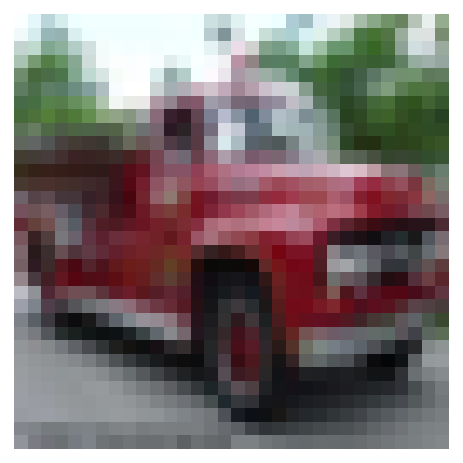

In [23]:
plt.imshow(np.moveaxis(ex, 0, 2), interpolation='nearest')
plt.axis('off')

In [24]:
noise = np.random.normal(0, 0.05, ex.shape)

In [25]:
ex = ex + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

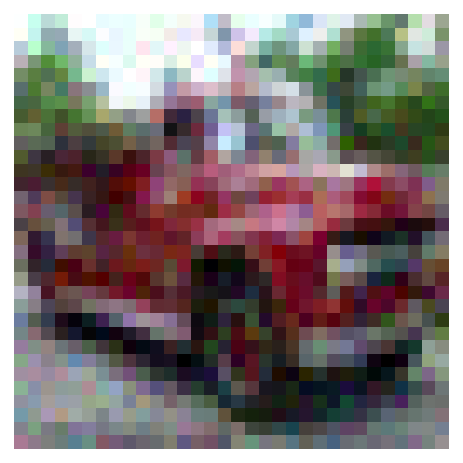

In [26]:
plt.imshow(np.moveaxis(ex, 0, 2), interpolation='nearest')
plt.axis('off')

In [11]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[25, 25, 25],
                                   kernels_size_and_stride=[(4, 2), (5, 2), (2, 1)],
                                   n_units_in_fc_hidden_layers=[],
                                   classes=classes,
                                   use_gpu=True)
rho = 0.001
epochs = 2000
nnet.train(Xtrain, Ttrain, epochs, learning_rate=rho, verbose=True)

Epoch 200 error 1.22608
Epoch 400 error 1.02417
Epoch 600 error 0.91869
Epoch 800 error 0.85401
Epoch 1000 error 0.81064
Epoch 1200 error 0.77162
Epoch 1400 error 0.74044
Epoch 1600 error 0.71340
Epoch 1800 error 0.70170
Epoch 2000 error 0.67179


In [12]:
classes, Y    = nnet.use(Xtrain)
train_percent = ml.percent_correct(Ttrain, classes)
classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)
print(f'Train Percentage: {train_percent}, Test Percentage: {test_percent}')

Train Percentage: 77.058, Test Percentage: 61.839999999999996


In [13]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 65.0  3.7  7.0  2.0  2.0  0.6  1.4  2.3 11.3  4.7
 1 |  3.7 71.1  0.9  1.0  1.1  0.3  1.7  1.1  3.6 15.5
 2 |  7.4  1.3 48.6  6.4 10.9  8.1  8.7  5.4  1.3  1.9
 3 |  2.4  1.1  9.8 41.5  7.7 20.6  7.9  4.7  1.7  2.6
 4 |  2.6  0.5  9.6  6.1 55.7  5.2  7.7  9.8  1.8  1.0
 5 |  1.1  0.6  6.5 17.3  6.0 53.6  4.5  6.9  2.3  1.2
 6 |  1.5  0.7  7.3  7.2  6.7  3.2 69.9  1.2  0.9  1.4
 7 |  2.5  0.4  4.6  5.5  8.5  7.0  1.5 66.3  0.6  3.1
 8 |  9.0  4.9  1.1  2.1  1.3  0.5  0.8  0.5 76.4  3.4
 9 |  5.3 11.4  1.0  1.6  1.1  1.1  2.0  1.9  4.3 70.3


Total of 1569 misclassified samples,
      with a 33.850% difference from test by adding noise with 0.1
(10000, 3, 32, 32) (10000, 3, 32, 32)


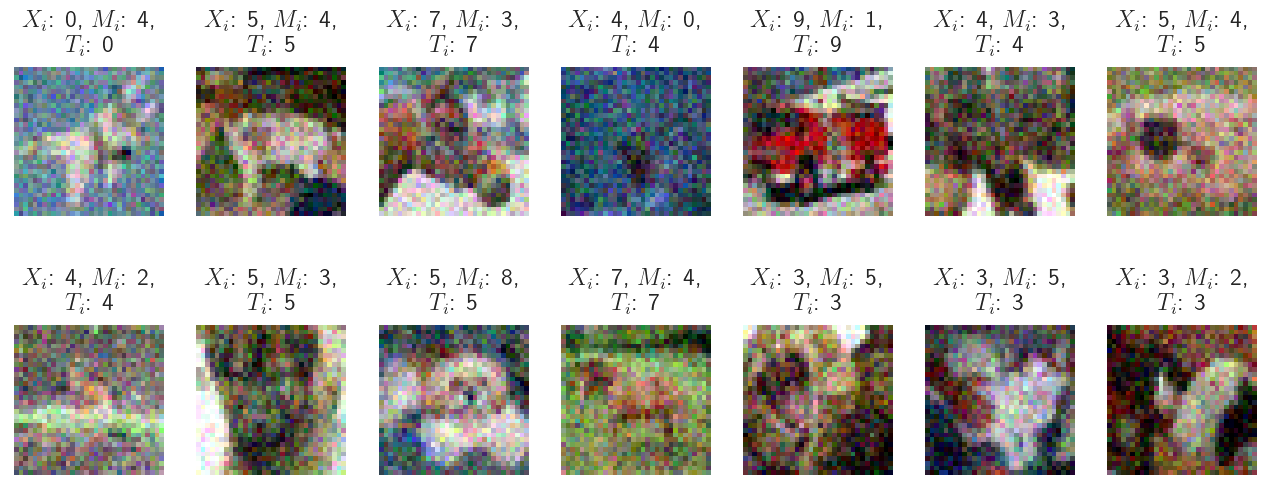

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [24]:
noise_variance = 0.1
Xcopy = per.add_image_noise(Xtest, noise_variance)
diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)
print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by adding noise with {noise_variance}''')
per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_1var_noise.pdf')
print(class_names)

In [25]:
index = 1675
augmented = []
for i in np.linspace(0.005, 0.2, 14):
    augmented.append(per.add_image_noise(Xtest[index], i))
augmented = np.array(augmented)

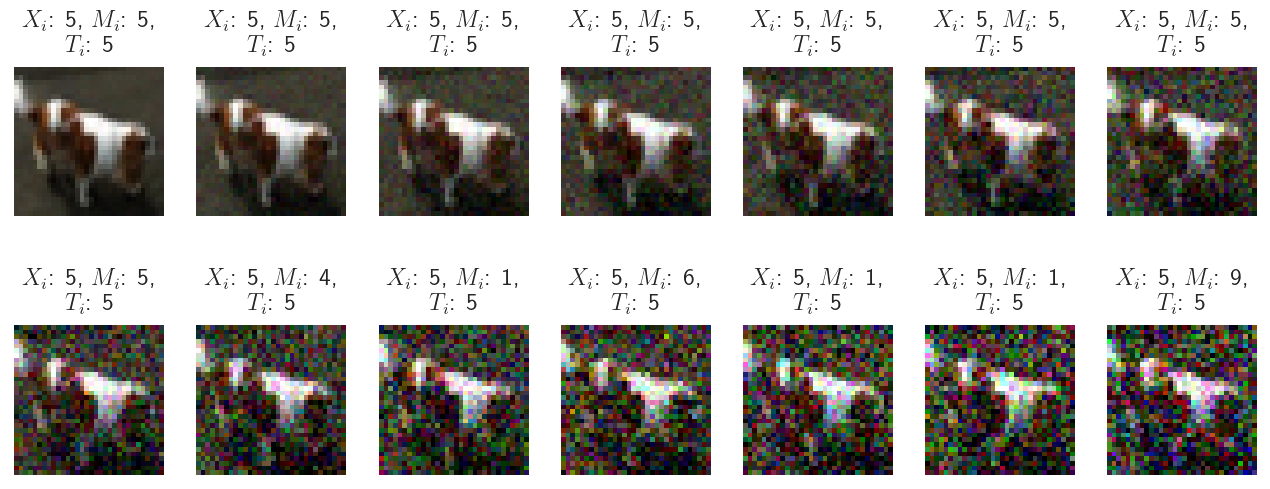

In [26]:
plt.figure(figsize=(9, 4))

Xset_class, _ = nnet.use(Xtest[index:index+1])
print()
for i in range(14):
    plt.subplot(2, 7, i + 1)
    plt.imshow(np.moveaxis(augmented[i, ...], 0, 2), interpolation='nearest')
    
    Xcopy_class, _ = nnet.use(augmented[i:i+1])
    plt.title('$X_i$: {0}, $M_i$: {1},\n$T_i$: {2}'.format(Xset_class[0][0],
                                                           Xcopy_class[0][0],
                                                           Ttest[index][0]))
    plt.axis('off')
plt.tight_layout();
plt.savefig('./media/gradient_noise.pdf', bbox_inches='tight')
plt.show();

Total of 1569 misclassified samples,
      with a 33.850% difference from test by adding noise with 0.01
(10000, 3, 32, 32) (10000, 3, 32, 32)


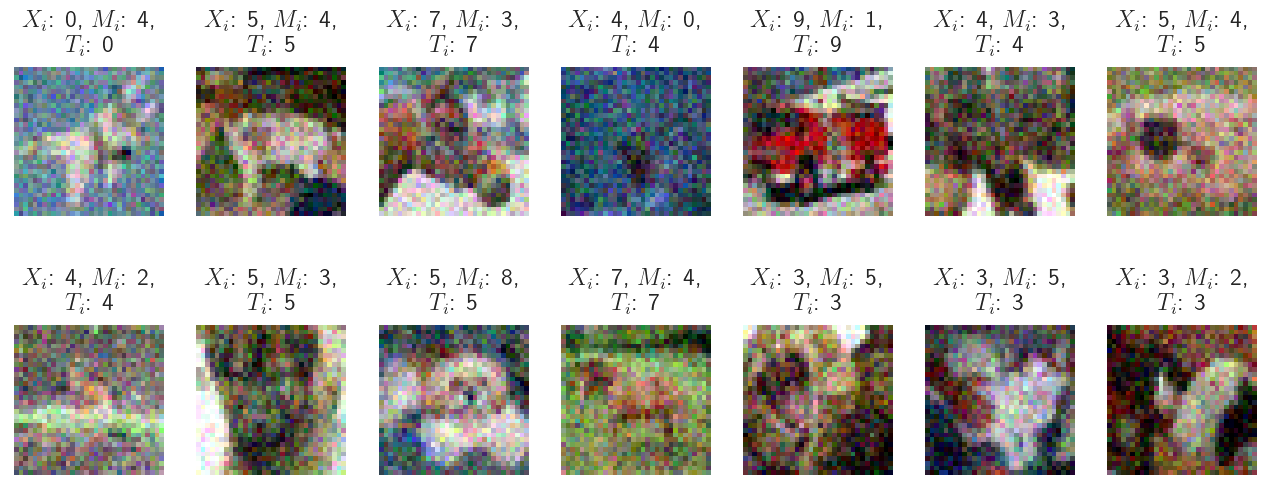

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [27]:
noise_variance = 0.01
# Xcopy = per.add_image_noise(Xtest, noise_variance)
diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)
print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by adding noise with {noise_variance}''')
per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_1var_noise.pdf')
print(class_names)

In [36]:
x, y, yerr = per.test_increasing_noise(nnet, Xtest, Ttest, (0.005, 0.1), 5, 25)

FloatProgress(value=0.0, max=125.0)

In [37]:
(x, y, yerr)

(array([0.005  , 0.02875, 0.0525 , 0.07625, 0.1    ]),
 array([ 1.8512, 10.3952, 18.7032, 26.8928, 34.5272]),
 array([0.07936347, 0.28445203, 0.2248861 , 0.42884515, 0.40086427]))

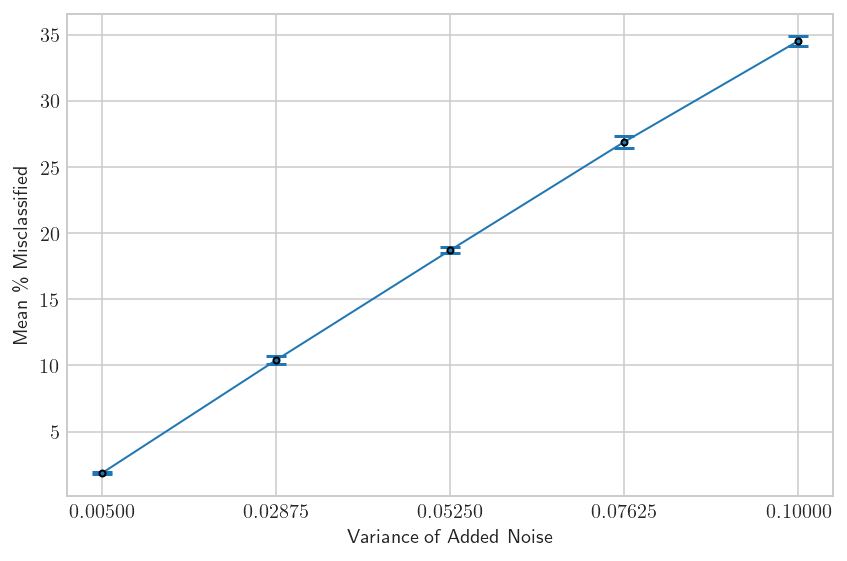

In [40]:
plt.figure(figsize=(6, 4))

plt.errorbar(x, y, yerr=yerr, marker='.',
             lw=1, capsize=5, capthick=1.5, markeredgecolor='k')

plt.xlabel('Variance of Added Noise')
plt.ylabel('Mean \% Misclassified')
plt.xticks(x)
plt.grid(True); plt.tight_layout()
plt.savefig('media/noise_variance_linear.pdf', bbox_inches='tight')
plt.show()